In [1]:
import os
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
###############################
####     Apercu Données     ###
###############################
data = pd.read_csv('data/group3/config_1/6_7.csv')
u = data.describe().T.drop('count', axis=1).T
display(u)

,t,raw_acceleration_x,raw_acceleration_y,raw_acceleration_z,rotation_speed_x,rotation_speed_y,rotation_speed_z,magnetic_field_x,magnetic_field_y,magnetic_field_z
mean,25.603862,0.223696,0.283043,-9.858043,0.005435,-0.003478,-0.205217,-9.214783,-10.540217,37.940870
std,0.301967,2.972517,2.025333,0.356748,0.048475,0.031848,0.812586,0.634605,1.625454,0.882222
min,25.097502,-8.720000,-3.620000,-10.520000,-0.190000,-0.120000,-1.650000,-10.250000,-13.370000,35.750000
25%,25.350487,-0.995000,-1.167500,-10.110000,-0.010000,-0.010000,-0.960000,-9.750000,-11.890000,37.370000
50%,25.604265,0.105000,0.275000,-9.870000,0.000000,0.000000,0.000000,-9.000000,-10.060000,37.750000
75%,25.857073,2.425000,1.507500,-9.720000,0.020000,0.000000,0.305000,-9.000000,-9.370000,38.875000
max,26.110399,5.090000,4.330000,-9.020000,0.150000,0.110000,1.550000,-7.500000,-7.870000,39.370000


* si on re-echantillone 1 aquisition, elle sera certainement differente des autres aquisition

=> on prend la moyenne d'echantillonage de tous les echantillons


In [168]:
#####################################
## integration continue            ##
#####################################

from scipy.integrate import cumtrapz

df=data
df['velocity_x'] = cumtrapz(df['raw_acceleration_x'], df['t'], initial=0)
df['position_x'] = cumtrapz(df['velocity_x'], df['t'], initial=0)

df['velocity_y'] = cumtrapz(df['raw_acceleration_y'], df['t'], initial=0)
df['position_y'] = cumtrapz(df['velocity_y'], df['t'], initial=0)

df['velocity_z'] = cumtrapz(df['raw_acceleration_z'], df['t'], initial=0)
df['position_z'] = cumtrapz(df['velocity_z'], df['t'], initial=0)

In [328]:
#####################################
## integration discrete            ##
#####################################

def double_integrate(df, col):
    df.sort_values(by='t', inplace=True)
    velocities = df[col].cumsum()
    positions = velocities.cumsum()
    return positions

data['pos_x'] = double_integrate(data,'raw_acceleration_x')
data['pos_y'] = double_integrate(data,'raw_acceleration_y')
data['pos_z'] = double_integrate(data,'raw_acceleration_z')


In [329]:
sns.set_style("darkgrid")


#x1 = data.raw_acceleration_x
#y1 = data.raw_acceleration_y
#z1 = data.raw_acceleration_z

#x1 = data.quaternion_x
#y1 = data.quaternion_y
#z1 = data.quaternion_z

x1 = data.pos_x
y1 = data.pos_y
z1 = data.pos_z

# x1 = df.position_x
# y1 = df.position_y
# z1 = df.position_z

plt.figure(figsize=(6, 5))
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(df, x=x1, y=y1, z=z1)
fig.show()

<Figure size 600x500 with 0 Axes>

In [321]:
###############################
####     Données 2022       ###
###############################

################################
##   juste MEAN / STD         ##
################################

directory = 'data/data_2022'
all_data=[]
for i in os.listdir(directory):
    for file in os.listdir(directory+f"/{i}"):
        if pd.read_csv(directory+f"/{i}/"+file).shape[0] != 0:  # 1 fichier était vide 
            in_ =(pd.read_csv(directory+f"/{i}/"+file))
            u = in_.describe().T[['mean','std']].T
            out_ = pd.DataFrame(pd.concat([u.iloc[0], u.iloc[1]], axis=0)).T
            out_['label'] = i
            all_data.append(out_)
to_test = pd.concat(all_data, axis=0)

In [14]:
liste = os.listdir(directory)

In [18]:
liste[0].split('_')[3].split('.')[0]

'7'

In [20]:
###############################
####     Données 2023       ###
###############################

################################
##   juste MEAN / STD         ##
################################


import os
directory = 'data/v_config1-lcb'#group3/config_1'#/config_3'   # change here to get more data
labels=[]
all_data=[]
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    data = pd.read_csv(f)
    u = data.describe().T[['mean','std']].T
    
    number = pd.DataFrame(pd.concat([u.iloc[0], u.iloc[1]], axis=0)).T
    if directory == 'data/config1':
        number['label'] = filename[0]
    elif directory == 'data/h_config1-lcb':
        number['label'] = filename[2]
    elif directory == 'data/v_config1-lcb':
        number['label'] = filename[10]
        number['iteration'] = filename.split('_')[3].split('.')[0]
    else :
        number['label'] = filename[0]
        
    all_data.append(number)

to_test = pd.concat(all_data)


# enleve la colonne iteratiuon
if 'iteration' in to_test:
    to_test.drop(columns='iteration', inplace=True)


#rename columns to get features importance
new_column_names = [('mean_' + to_test.columns[i]) for i in range(10)] + [('std_' + to_test.columns[i]) for i in range(10)] + ['label']
to_test.columns= new_column_names

In [12]:
to_test

,mean_t,mean_raw_acceleration_x,mean_raw_acceleration_y,mean_raw_acceleration_z,mean_rotation_speed_x,mean_rotation_speed_y,mean_rotation_speed_z,mean_magnetic_field_x,mean_magnetic_field_y,mean_magnetic_field_z,...,std_raw_acceleration_x,std_raw_acceleration_y,std_raw_acceleration_z,std_rotation_speed_x,std_rotation_speed_y,std_rotation_speed_z,std_magnetic_field_x,std_magnetic_field_y,std_magnetic_field_z,label
0,24.604460,9.427051,0.719359,-0.620256,-0.150513,-0.117436,-0.110000,-45.517821,15.847949,-2.123846,...,4.821092,2.013747,1.970886,0.427159,1.061095,0.427764,2.292275,4.294027,10.024040,1
0,133.901335,8.550494,3.455556,-2.152963,0.183951,-0.041605,-0.296667,-49.349136,7.459383,-0.636543,...,4.994937,4.946531,3.469076,0.831674,1.386727,0.826707,1.720843,9.499404,8.581532,9
0,265.420625,9.013158,2.397807,-1.745702,-0.049211,-0.088596,-0.125789,-48.118333,4.467544,-3.445789,...,2.953571,2.951886,3.740314,1.037891,0.671157,0.765532,2.097428,6.053845,7.778235,0
0,72.241357,8.001683,-4.846634,-2.121683,-0.300594,-0.004356,0.027228,-23.003663,37.274455,-9.004554,...,6.765224,5.332415,4.031470,1.336040,1.397092,0.724857,6.104529,4.132449,10.309305,7
0,20.228836,9.500381,0.123810,-0.565714,-0.041619,-0.045619,-0.138190,-45.629048,18.803905,-2.617714,...,2.089984,3.902031,1.514411,0.805799,0.327432,0.266053,1.851233,5.907518,6.659081,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,132.903289,8.514535,-1.831628,-3.449070,0.158488,-0.423488,0.113140,-47.028488,19.050233,-1.054535,...,4.924538,6.350463,4.818311,1.316642,0.966595,0.909793,5.741658,4.648246,9.627117,5
0,31.660618,9.717129,0.570000,-0.773168,0.085545,-0.017327,-0.162970,-47.134752,16.570000,-2.949901,...,2.676173,3.612171,1.841000,0.943571,0.462318,0.335644,1.632816,5.881943,6.976105,3
0,227.721238,7.714328,4.362388,-3.487015,0.354030,0.074925,-0.005522,-49.762388,-8.918657,1.710299,...,6.844509,6.935323,6.270272,1.143436,1.641612,1.390144,2.104048,4.435704,9.423506,9
0,124.711890,8.964815,1.164691,-3.279383,-0.107284,0.039383,-0.133951,-45.919753,14.813580,6.736296,...,3.272555,3.435817,3.598820,1.024412,1.043442,0.612315,3.339033,3.782817,9.963763,0


In [3]:
################################
##   sauf COUNT / ...         ##
################################

import os

def linearize(u):
    all=[]
    for line in range(len(u)):
        all.append(u.iloc[line])
    return pd.concat(all, axis=0).T

directory = 'data/group3/config_3'
labels=[]
all_data=[]
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    data = pd.read_csv(f)
    # ===> feature engineering / si pas **0.5 score plus mauvais
    # data['feat1'] = (abs(data.raw_acceleration_x) + abs(data.raw_acceleration_y) + abs(data.raw_acceleration_z))**(0.5)  
    # ===> feature engineering  ---> quaternion <---
    # data['feat_x'] =  data.quaternion_x**3
    # data['feat_y'] =  data.quaternion_y**3
    # data['feat_z'] =  data.quaternion_z**3
    # data.drop(columns=['quaternion_x','quaternion_y','quaternion_z'], inplace=True)

    # data['feat_x'] =  data.quaternion_x**2
    # data['feat_y'] =  data.quaternion_y**2
    # data['feat_z'] =  data.quaternion_z**2
    # data.drop(columns=['quaternion_x','quaternion_y','quaternion_z'], inplace=True)
    # ===> feature engineering 
    #data['feat_x'] = data.magnetic_field_x**2
    #data['feat_y'] = data.magnetic_field_y**2
    #data['feat_z'] = data.magnetic_field_z**2

    #data['feat_x1'] = data.raw_acceleration_x**(2)
    #data['feat_y1'] = data.raw_acceleration_y**(2) 
    #data['feat_z1'] = data.raw_acceleration_z**(2)

    u = data.describe().T.drop(['count'], axis=1)
    number = pd.DataFrame(linearize(u)).T
    number['label'] = filename[0]
    all_data.append(number)
    
to_test = pd.concat(all_data)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(to_test.drop("label", axis=1), to_test["label"], test_size=0.3, random_state=42, stratify=to_test["label"])

# Créer un modèle d'arbre de décision
model = DecisionTreeClassifier()

# Entraîner le modèle
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
predictions = model.predict(X_test)

# Calculer la précision du modèle
accuracy = accuracy_score(y_test, predictions)
print("Précision du modèle:", accuracy)

Précision du modèle: 0.9473684210526315


In [33]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedShuffleSplit
                                               
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
cv_results = cross_validate(model, X_train, y_train, cv=sss)
cv_results = pd.DataFrame(cv_results)
cv_results

print(
    "Generalization score without hyperparameters"
    f" tuning:\n{cv_results['test_score'].mean():.3f} ±"
    f" {cv_results['test_score'].std():.3f}"
)




Generalization score without hyperparameters tuning:
0.849 ± 0.069


              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        11
           3       1.00      0.70      0.82        10
           4       0.82      0.90      0.86        10
           5       1.00      0.62      0.76        13
           6       0.88      0.93      0.90        15
           7       0.93      1.00      0.97        14
           8       0.69      1.00      0.81        11
           9       0.80      0.80      0.80        10

    accuracy                           0.88       112
   macro avg       0.90      0.88      0.88       112
weighted avg       0.90      0.88      0.88       112



<Axes: >

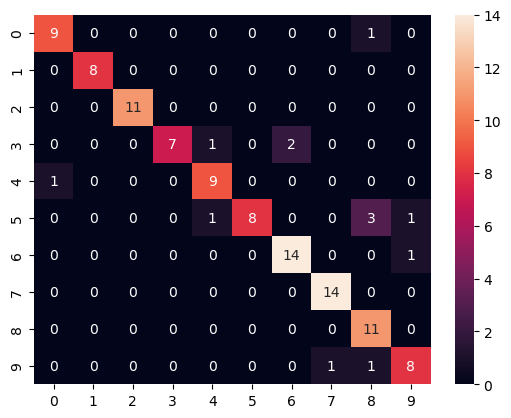

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

preds_ = model.predict(X_test)

print(classification_report(y_test,preds_))
sns.heatmap(confusion_matrix(y_test,preds_), fmt=".2g", annot=True)

In [10]:
##############################################
# on coupe la serie temporelle en n segments #
##############################################

import os
directory = 'data/group3/config_1'
n_segments = 4
labels=[]
all_data=[]
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    data = pd.read_csv(f)

    # on ajoute les stats des differents segments de l'aquisition
    n = len(data)//n_segments   # nbe de points par quartiers
    quartiles_ =[]
    for i in range(n_segments):
        quart_ = data[i*n:(i+1)*n]#.drop(columns='t')
        int_ = quart_.describe().T[['mean','std']].T
        out_ = pd.DataFrame(pd.concat([int_.iloc[0], int_.iloc[1]], axis=0)).T
        quartiles_.append(out_)

    to_concat=[]
    for i in range(n_segments):
        to_concat.append(quartiles_[i])


    # on ajoute les stats de la serie temporelle complete
    u = data.describe().T[['mean','std']].T
    for i in range(u.shape[0]):
        to_concat.append(pd.DataFrame(pd.concat([u.iloc[0], u.iloc[1]], axis=0)).T)


    number = pd.DataFrame(pd.concat(to_concat, axis=1))
    number['label'] = filename[0]
    all_data.append(number)

to_test = pd.concat(all_data, axis=0)
to_test.shape


(223, 121)

# test different modele

In [183]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
#from catboost import CatBoostClassifier

In [184]:
##################################
## instancier different modeles ##
##################################

# Assuming 'X' is your feature matrix and 'y' is the target variable
X_train, X_test, y_train, y_test = train_test_split(to_test.drop("label", axis=1), to_test["label"], test_size=0.3, random_state=42)


# Define a list of classifiers to test
classifiers = [
    ('Decision tree', DecisionTreeClassifier()),
    ('Logistic regr', LogisticRegression(max_iter=10000)),
    ('SVC', SVC()),
    ('Random Forest', RandomForestClassifier()),    
]

# Create a pipeline for each classifier
pipelines = []
for name, model in classifiers:
    pipelines.append((name, Pipeline([(name, model)])))


In [187]:
##################################
## tester different modeles     ##
##################################

# evaluate with cross_val

for name, model in pipelines:
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name}: Mean Accuracy - {scores.mean():.4f} +/- {scores.std():.4f}")
    model.fit(X_train, y_train)
    preds_ = model.predict(X_test)

    print("==> Accuracy on the test set:",round(accuracy_score(y_test,preds_),4))


Decision tree: Mean Accuracy - 0.6800 +/- 0.0702
==> Accuracy on the test set: 0.806
Logistic regr: Mean Accuracy - 0.7435 +/- 0.0736
==> Accuracy on the test set: 0.7761
SVC: Mean Accuracy - 0.3583 +/- 0.0668
==> Accuracy on the test set: 0.4627
Random Forest: Mean Accuracy - 0.8972 +/- 0.0380
==> Accuracy on the test set: 0.9403


Text(0.5, 1.0, 'Variable importance plot')

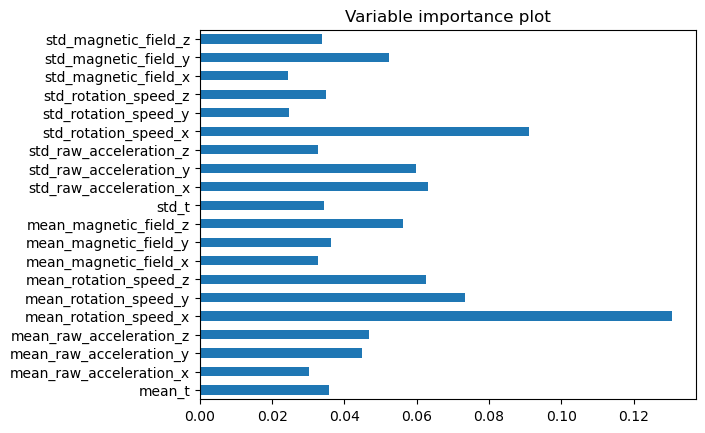

In [68]:
##############################
#### variable importance #####
##############################

model = RandomForestClassifier()
model.fit(X_train, y_train)
pd.Series(model.feature_importances_, index=X_train.columns).plot.barh()
plt.title("Variable importance plot")


Random Forest: Mean Accuracy - 0.8458 +/- 0.0523


Text(0.5, 1.0, 'Variable importance plot')

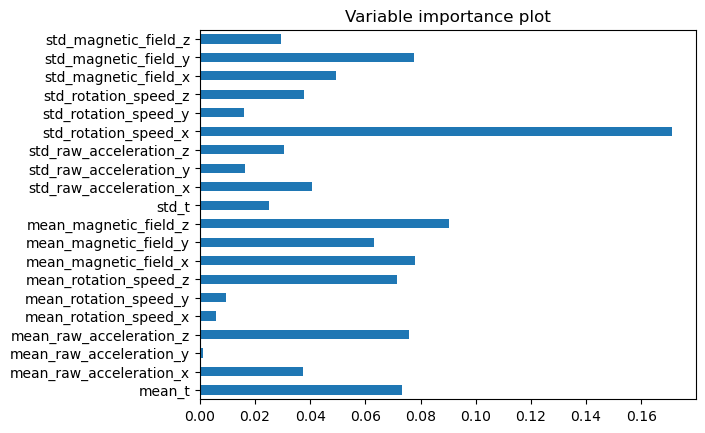

In [9]:
######################################
###  entrainement test de XGBoost  ###
######################################

scores = cross_val_score(XGBClassifier(), X_train, y_train.apply(lambda x:int(x)), cv=5, scoring='accuracy')
print(f"{name}: Mean Accuracy - {scores.mean():.4f} +/- {scores.std():.4f}")

model = XGBClassifier()
model.fit(X_train, y_train.apply(lambda x:int(x)))
pd.Series(model.feature_importances_, index=X_train.columns).plot.barh()
plt.title("Variable importance plot")

In [10]:
preds_ = model.predict(X_test)

print("==> Accuracy on the test set:",round(accuracy_score(y_test,preds_),4))

# reservoir computing

In [2]:
import reservoirpy as rpy

rpy.verbosity(0)  # no need to be too verbose here
rpy.set_seed(42) # make things reproductible

In [3]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(100, lr=0.5, sr=0.9)
ridge = Ridge(ridge=1e-7)

esn_model = reservoir >> ridge

In [4]:
import os
import pandas as pd
import numpy as np 
directory = 'data/group3/config_1'#/config_3'   # change here to get more data
labels=[]
label=[]
all_data=[]
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    data = pd.read_csv(f)
    all_data.append(np.array(data))
    labels.append(np.array([int(filename[0])]*len(data)).reshape(-1,1))
    
    label.append(filename[0])



In [15]:
####################################
### preprocessing y pour RC       ##
####################################


from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc_label = enc.fit_transform(np.array(label).reshape(-1,1)).toarray()

new_label=[]
for i in range(len(all_data)):
    new_label.append(np.tile(enc_label[i], (len(all_data[i]), 1)))


In [ ]:
enc.

In [16]:
X_train, X_test, y_train, y_test = all_data[:178], all_data[178:], new_label[:178],  new_label[178:]

esn_model = esn_model.fit(X_train, y_train, warmup=10)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [17]:
print(reservoir.is_initialized, ridge.is_initialized, ridge.fitted)


True True True


In [18]:
Y_pred = esn_model.run(X_test)

IndexError: index 433 is out of bounds for axis 0 with size 55